In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/RL_NLP/RL_Agents/PPO_Agent/PPO_Docker_Gridworld

/content/drive/MyDrive/RL_NLP/RL_Agents/PPO_Agent/PPO_Docker_Gridworld


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import multiprocessing
from simple_gridworld import SimpleGridWorld
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


class ActorCriticNN(nn.Module):
    def __init__(self,num_inputs,num_actions,hidden_size):
        super(ActorCriticNN, self).__init__()

        self.Critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,1)
        )

        self.Actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_actions),
        )

        def init_weights(param):
            if isinstance(param,nn.Linear):
                nn.init.normal_(param.weight, mean=0, std=0.1)
                nn.init.constant_(param.bias, 0.1)
        self.apply(init_weights)

    def forward(self,x):
        value = self.Critic(x)
        mu_prob = self.Actor(x)
        mu = Categorical(logits=mu_prob)
        return mu, value


def RESETS(envs):
    return envs.reset()
    # def reset(env):
    #     return env.reset()
    # pool = multiprocessing.Pool()
    # states = pool.map(reset,envs)
    # pool.close()
    # pool.join()
    # return states


def STEPS(envs,actions):
    return envs.action_step(actions.item())
    # def step(env,action):
    #     return env.step(action)
    # pool = multiprocessing.Pool()
    # states, rewards, terminations = pool.map(step,envs,actions)
    # pool.close()
    # pool.join()
    # return states, rewards, terminations


def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]



def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [4]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

def test_env(vis=False):
    state = env.reset()
    if vis:
        env.printGrid()
        print()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor([state]).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample()
        next_state, reward, done = STEPS(env,action.cpu().numpy())
        state = next_state
        if vis:
            env.printGrid()
            print()
        total_reward += reward
    return total_reward

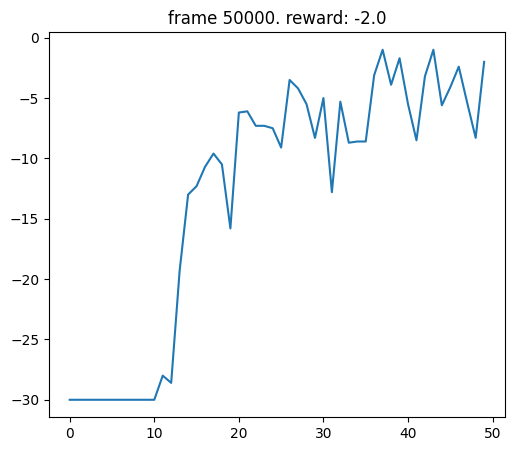

In [5]:
if __name__=='__main__':
    use_cuda = torch.cuda.is_available()
    device   = torch.device("cuda" if use_cuda else "cpu")
    num_steps = 25 # 5x5 grid world
    # N = 10 # number of parallel environments
    # envs = [SimpleGridWorld() for _ in range(N)]
    # num_inputs  = envs[0].ip_shape
    # num_outputs = envs[0].op_shape
    env = SimpleGridWorld()
    num_inputs  = env.ip_shape
    num_outputs = env.op_shape
    max_frames = 50000
    frame_idx = 0
    early_stopping = False
    # Neural Network Hyper params:
    hidden_size      = 256
    lr               = 1e-3
    mini_batch_size  = 5
    ppo_epochs       = 4
    # threshold_reward = envs[0].threshold_reward
    threshold_reward = env.threshold_reward
    # Neural Network
    model = ActorCriticNN(num_inputs, num_outputs, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    test_rewards = []

    while frame_idx < max_frames and not early_stopping:
        log_probsArr = []
        valuesArr    = []
        statesArr    = []
        actionsArr   = []
        rewardsArr   = []
        masksArr     = []
        entropy = 0
        # states = RESETS(envs)
        state = RESETS(env)
        for _ in range(num_steps):
            state = torch.FloatTensor([state]).to(device)
            dist, value = model(state)

            action = dist.sample()
            # next_states, rewards, done = STEPS(envs,actions.cpu().numpy())
            next_state, reward, done = STEPS(env,action.cpu().numpy())

            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            valuesArr.append(value)
            log_probsArr.append(torch.FloatTensor([log_prob]).unsqueeze(1).to(device))
            rewardsArr.append(torch.FloatTensor([reward]).unsqueeze(1).to(device))
            masksArr.append(torch.FloatTensor([1 - done]).unsqueeze(1).to(device))
            actionsArr.append(torch.FloatTensor([action]).unsqueeze(1).to(device))
            statesArr.append(state)

            state = next_state
            frame_idx += 1

            if frame_idx % 1000 == 0:
                test_reward = np.mean([test_env() for _ in range(10)])
                test_rewards.append(test_reward)
                plot(frame_idx, test_rewards)
                if test_reward > threshold_reward: early_stop = True

        next_state = torch.FloatTensor([next_state]).to(device)
        _, next_value = model(next_state)
        returns = compute_gae(next_value, rewardsArr, masksArr, valuesArr)

        returns   = torch.cat(returns).detach()
        log_probsArr = torch.cat(log_probsArr).detach()
        valuesArr    = torch.cat(valuesArr).detach()
        statesArr    = torch.cat(statesArr)
        actionsArr   = torch.cat(actionsArr)
        advantage = returns - valuesArr
        ppo_update(ppo_epochs, mini_batch_size, statesArr, actionsArr, log_probsArr, returns, advantage)

### See the agent walk.

In [6]:
test_env(vis=True)

0 1 0 0 0 
0 0 0 0 0 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 0 

0 0 1 0 0 
0 0 0 0 0 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 0 

0 0 0 0 0 
0 0 1 0 0 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 0 

0 0 0 0 0 
0 0 0 1 0 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 0 

0 0 0 0 0 
0 0 0 0 1 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 0 

0 0 0 0 0 
0 0 0 0 0 
3 3 3 3 1 
0 0 0 0 0 
0 0 0 2 0 

0 0 0 0 0 
0 0 0 0 0 
3 3 3 3 0 
0 0 0 0 1 
0 0 0 2 0 

0 0 0 0 0 
0 0 0 0 0 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 1 

0 0 0 0 0 
0 0 0 0 0 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 1 

0 0 0 0 0 
0 0 0 0 0 
3 3 3 3 0 
0 0 0 0 0 
0 0 0 2 1 



2